# Montana Oil Data Exploration and Machine Learning

The purpose of this notebook is to outline the process for collecting oil and gas data from the state of Montana, and data from frac focus. We will perform exploratory data analysis a subset of this data with horizontal well completions.

In [4]:
# importing libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from src.mt_oil.data.loader import pull_ff_data, pull_prod_data, pull_well_data
from src.mt_oil.processing.features import preprocess_ff_data, preprocess_well_data, preprocess_prod_data, merge_data
from src.mt_oil.models.pipeline import train_and_evaluate


In [5]:
# pull data
lease_prod_df, well_prod_df = pull_prod_data()
well_data_df = pull_well_data()



# View Data
Let's start by taking a look at these 3 files pulled from the .zip file. There are three flat files. `lease_prod_df` contains production reported on a lease basis, `well_prod_df` contains production on a per well monthly basis, and `well_data_df` contains the well information (Producting status, field, horizontal, vertical drill profile, etc.)

In [6]:
lease_prod_df.head()

,Lease_Unit,Rpt_Date,Dt_Receive,Amnd_Rpt,Dt_Amend,OpNo,CoName,StartIvn_OilCd,Oil_Prod,Gas_Prod,...,UseOil,UseGas,OilInj,GasInj,WtrInj,WtrTo_Pit,Other_Oil,Other_Gas,Other_Wtr,Dt_Mod
0,2,01/31/2001,03/15/2001,False,NaN,5385,EnCana Oil & Gas (USA) Inc.,0.0,0.0,353.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,05/18/2001
1,2,02/28/2001,04/01/2001,False,NaN,5385,EnCana Oil & Gas (USA) Inc.,0.0,0.0,188.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,06/11/2001
2,2,03/31/2001,05/18/2001,False,NaN,5385,EnCana Oil & Gas (USA) Inc.,0.0,0.0,341.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,07/12/2001
3,2,04/30/2001,05/25/2001,False,NaN,5385,EnCana Oil & Gas (USA) Inc.,0.0,0.0,369.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,08/03/2001
4,2,05/31/2001,07/19/2001,False,NaN,5385,EnCana Oil & Gas (USA) Inc.,0.0,0.0,336.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,09/07/2001


In [7]:
lease_prod_df.describe()

,Lease_Unit,OpNo,StartIvn_OilCd,Oil_Prod,Gas_Prod,Wtr_Prod,Oil_Sold,Gas_Sold,OilSpill,WtrSpill,FlarVnt_Gas,UseOil,UseGas,OilInj,GasInj,WtrInj,WtrTo_Pit,Other_Oil,Other_Gas,Other_Wtr
count,1.528703e+06,1.528703e+06,1.510282e+06,1.528693e+06,1.528074e+06,1.527884e+06,1.527882e+06,1.528698e+06,1.527750e+06,96256.000000,1.528699e+06,1.527745e+06,1.528700e+06,1.527745e+06,1.528699e+06,1.504348e+06,1.504358e+06,1.517114e+06,1.528699e+06,1.504149e+06
mean,1.401829e+04,1.686853e+03,1.009611e+02,3.989290e+02,1.521475e+03,2.675452e+03,3.988127e+02,1.050776e+03,2.648994e-03,1.628023,5.789259e+01,3.134555e-02,4.665755e+01,4.079215e-03,3.628116e+02,1.588530e+03,2.864987e+02,1.230712e-01,2.856413e+00,2.004344e+02
std,4.083045e+04,2.309141e+03,2.071281e+02,3.379548e+03,4.317523e+04,3.418983e+04,3.380432e+03,8.964201e+03,6.108090e-01,213.410424,2.493351e+03,1.693196e+00,4.154670e+02,1.085467e+00,4.213800e+04,3.106284e+04,5.074238e+03,1.407550e+01,1.352709e+02,7.603406e+03
min,2.000000e+00,4.000000e+00,-8.150000e+02,-4.020000e+02,0.000000e+00,-5.150000e+02,-2.300000e+02,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,-1.390000e+02,-8.190000e+02,-4.800000e+01,0.000000e+00,-9.300000e+01,-5.000000e+01,-8.580000e+03,-5.540000e+02,-7.055000e+04
25%,2.711000e+03,3.690000e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,5.320000e+03,5.800000e+02,0.000000e+00,0.000000e+00,1.230000e+02,0.000000e+00,0.000000e+00,5.800000e+01,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,7.491000e+03,1.720000e+03,1.500000e+02,1.200000e+02,6.600000e+02,1.180000e+02,1.220000e+02,5.450000e+02,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,9.900150e+05,1.230600e+04,8.493000e+03,2.318970e+05,6.293885e+06,2.096867e+06,2.319860e+05,6.788670e+05,2.480000e+02,34799.000000,5.762540e+05,3.120000e+02,7.351400e+04,9.890000e+02,6.293885e+06,2.096867e+06,4.854860e+05,3.000000e+03,2.473100e+04,8.252006e+06


In [8]:
well_prod_df.head()

,API_WellNo,Rpt_Date,ST_FMTN_CD,Formation,Lease_Unit,OpNo,CoName,BBLS_OIL_COND,MCF_GAS,BBLS_WTR,DAYS_PROD,AMND_RPT,DT_MOD
0,25051211360000,12/31/2020,SWI,Swift,NaN,399.0,"MCR, LLC",0.0,0.0,0,0.0,False,03/15/2021
1,25083212900000,01/31/2021,BAK,Bakken,NaN,564.0,Abraxas Petroleum Corporation,0.0,0.0,0,0.0,False,04/22/2021
2,25083213730000,01/31/2021,BAK,Bakken,NaN,564.0,Abraxas Petroleum Corporation,0.0,0.0,0,0.0,False,04/22/2021
3,25051211360000,01/31/2021,SWI,Swift,NaN,399.0,"MCR, LLC",0.0,0.0,0,0.0,False,05/03/2021
4,25041234290000,02/28/2021,EAG,Eagle,NaN,369.0,NorthWestern Corporation,0.0,0.0,0,0.0,False,03/25/2021


In [9]:
well_prod_df.describe()

,API_WellNo,Lease_Unit,OpNo,BBLS_OIL_COND,MCF_GAS,BBLS_WTR,DAYS_PROD
count,5.617339e+06,5.617281e+06,4.770235e+06,5.617337e+06,5.617338e+06,5.617339e+06,5.617266e+06
mean,2.506247e+13,9.037130e+03,1.747682e+03,1.593318e+02,5.600359e+02,1.036896e+03,1.939258e+01
std,3.385115e+10,4.020122e+04,2.396255e+03,6.769825e+02,3.627739e+03,6.045520e+03,2.262102e+01
min,2.500305e+13,-9.990000e+02,4.000000e+00,-4.020000e+02,-6.050000e+02,-4.120000e+03,-3.400000e+01
25%,2.503506e+13,1.615000e+03,3.210000e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.507122e+13,2.896000e+03,5.930000e+02,0.000000e+00,0.000000e+00,0.000000e+00,3.000000e+01
75%,2.509921e+13,4.986000e+03,1.720000e+03,2.600000e+01,4.210000e+02,5.900000e+01,3.100000e+01
max,2.511192e+13,9.900150e+05,1.230600e+04,4.985800e+04,3.608640e+05,5.958210e+05,3.633000e+03


In [10]:
well_data_df.head()

,API_WellNo,CoName,Well_Nm,Status,Type,MapSymbol,Wh_Twpn,Wh_Twpd,Wh_RngN,Wh_RngD,...,St_FldNo,Prod_Field,Field_No,Reg_Field,DTD,Lat,Long,DOR_ID,County,Slant
0,25001050000000,Hagenbarth,Benj. C. Crowley 1,P&A - Approved,Dry Hole,ADH,7,S,10,W,...,NaN,NaN,11001,Wildcat Beaverhead,812.0,45.25851,-112.79980,NaN,Beaverhead,Vertical
1,25001050010000,Beaverhead Alberta Oil Co.,Well 2,P&A - Approved,Dry Hole,ADH,8,S,9,W,...,NaN,NaN,11001,Wildcat Beaverhead,2500.0,45.09222,-112.67421,NaN,Beaverhead,Vertical
2,25001050020000,Beaverhead Alberta Oil Co.,Well 3,P&A - Approved,Dry Hole,ADH,8,S,9,W,...,NaN,NaN,11001,Wildcat Beaverhead,1225.0,45.09222,-112.67421,NaN,Beaverhead,Vertical
3,25001050030000,Beaverhead Alberta Oil Co.,Well 1,P&A - Approved,Dry Hole,ADH,8,S,9,W,...,NaN,NaN,11001,Wildcat Beaverhead,1800.0,45.09968,-112.66401,NaN,Beaverhead,Vertical
4,25001050040000,Big Dome Oil Co.,Well 1,P&A - Approved,Dry Hole,ADH,8,S,9,W,...,NaN,NaN,11001,Wildcat Beaverhead,100.0,45.10330,-112.64339,NaN,Beaverhead,Vertical


In [11]:
well_data_df.columns

Index(['API_WellNo', 'CoName', 'Well_Nm', 'Status', 'Type', 'MapSymbol',
       'Wh_Twpn', 'Wh_Twpd', 'Wh_RngN', 'Wh_RngD', 'Wh_Sec', 'Wh_Qtr',
       'Wh_Lot', 'Wh_FtNS', 'Wh_Ns', 'Wh_FtEW', 'Wh_EW', 'Permitted',
       'Spudded', 'Completed', 'St_FldNo', 'Prod_Field', 'Field_No',
       'Reg_Field', 'DTD', 'Lat', 'Long', 'DOR_ID', 'County', 'Slant'],
      dtype='object')

In [12]:
well_data_df.describe()

,API_WellNo,Wh_Twpn,Wh_RngN,Wh_Sec,Wh_Lot,Wh_FtNS,Wh_FtEW,St_FldNo,Field_No,DTD,Lat,Long,DOR_ID
count,4.184300e+04,41843.000000,41843.000000,41843.000000,1111.000000,41375.000000,41375.00000,25143.000000,4.184300e+04,41497.000000,41843.000000,41843.000000,14634.000000
mean,2.506075e+13,24.523481,25.324809,18.484191,4.294329,1302.901728,1329.41426,4505.767172,7.139256e+03,3951.041449,47.756926,-108.728080,11863.190652
std,3.459167e+10,11.593226,20.943590,10.168853,3.823676,715.040683,694.81586,2799.703936,1.287408e+05,3933.792724,1.219930,2.903000,66390.567585
min,2.500105e+13,1.000000,1.000000,1.000000,1.000000,0.000000,0.00000,5.000000,5.000000e+00,7.000000,44.541790,-114.984210,2.000000
25%,2.503106e+13,11.000000,5.000000,10.000000,2.000000,660.000000,660.00000,2400.000000,2.410000e+03,1536.000000,46.712120,-111.779685,1699.000000
50%,2.507121e+13,30.000000,20.000000,18.000000,3.000000,1205.000000,1300.00000,4820.000000,6.120000e+03,2318.000000,48.348760,-109.155890,3553.000000
75%,2.509505e+13,34.000000,45.000000,27.000000,5.000000,1980.000000,1980.00000,6680.000000,1.101500e+04,4775.000000,48.726805,-106.018250,6447.000000
max,2.511160e+13,133.000000,107.000000,36.000000,25.000000,7428.000000,4975.00000,11112.000000,2.633000e+07,27962.000000,48.998630,-104.034320,990015.000000


# Clean

Remove wells and leases that have no hydrocarbon production. This could be due to wells only producing water, or problems with reporting. 

In [13]:
well_prd_total = well_prod_df.groupby(['API_WellNo']).sum() #sum the producing streams by api
well_prd_total['BOE'] = well_prd_total['BBLS_OIL_COND'] + well_prd_total['MCF_GAS']/5.8 #get total bbls of oil equivalent
well_prd_total = well_prd_total[well_prd_total['BOE']>0] #drop wells that didn't produce any oil and/or gas
api_list = list(well_prd_total.index) #get list of the api #'s that are associated with wells that had non-zero production
well_prod_df = well_prod_df[well_prod_df['API_WellNo'].isin(api_list)]


In [14]:
lease_prd_total = lease_prod_df.groupby(['Lease_Unit']).sum() #sum the producing streams by lease unit
lease_prd_total['BOE'] = lease_prd_total['Oil_Prod'] + lease_prd_total['Gas_Prod']/5.8 #get total bbls of oil equivalent
lease_prd_total = lease_prd_total[lease_prd_total['BOE']>0] #drop leases that didn't produce any oil and/or gas
lease_list = list(lease_prd_total.index) #get list of the lease unit #'s that are associated with leases that had non-zero production
lease_prod_df = lease_prod_df[lease_prod_df['Lease_Unit'].isin(lease_list)]

# Horizontal Data

There are two ways that we can look at our data, we can choose to look through the lenses of leases which will contain a collection of 1 or more wells. The other is to perform analysis on a per well Basis. Each well will have a unique `API_WellNo` and each lease will be associated with a unique `Lease_Unit`. Our focus here will be on wells drilled horizontally, denoted by the `Slant` field in the `well_data_df`

In [15]:
hz_wells = well_data_df[well_data_df['Slant'] == 'Horizontal']
hz_wells_list = list(hz_wells['API_WellNo'])
hz_wells_prod = well_prod_df[well_prod_df['API_WellNo'].isin(hz_wells_list)]
hz_wells_prod

,API_WellNo,Rpt_Date,ST_FMTN_CD,Formation,Lease_Unit,OpNo,CoName,BBLS_OIL_COND,MCF_GAS,BBLS_WTR,DAYS_PROD,AMND_RPT,DT_MOD
195906,25083219070000,12/31/2001,RR,Red River,135.0,3430.0,Headington Oil Company LLC,9520.0,6595.0,15378,31.0,False,02/19/2002
195909,25083219070000,01/31/2002,RR,Red River,135.0,3430.0,Headington Oil Company LLC,8622.0,5890.0,13808,29.0,False,04/02/2002
195912,25083219070000,02/28/2002,RR,Red River,135.0,3430.0,Headington Oil Company LLC,8341.0,5773.0,13387,28.0,False,04/18/2002
195915,25083219070000,03/31/2002,RR,Red River,135.0,3430.0,Headington Oil Company LLC,5428.0,3758.0,11688,29.0,False,05/13/2002
195918,25083219070000,04/30/2002,RR,Red River,135.0,3430.0,Headington Oil Company LLC,6447.0,4689.0,12905,30.0,False,06/13/2002
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5368338,25083233130000,12/31/2024,BAK,Bakken,10537.0,1550.0,Continental Resources Inc,255.0,690.0,403,31.0,False,01/29/2025
5368339,25083233130000,01/31/2025,BAK,Bakken,10537.0,1550.0,Continental Resources Inc,245.0,593.0,384,31.0,False,02/28/2025
5368340,25083233130000,02/28/2025,BAK,Bakken,10537.0,1550.0,Continental Resources Inc,219.0,568.0,327,28.0,False,03/28/2025
5368341,25083233130000,03/31/2025,BAK,Bakken,10537.0,1550.0,Continental Resources Inc,211.0,664.0,345,31.0,False,04/29/2025


# FracFocus Data
The next step is to pull in the data from FracFocus which will help give us a better idea of the materials and volumes that were used in stimulating these horizontal wells. FracFocus records start being widely reported around 2012. 

In [16]:
FracFocusRegistry_df_MT, registryupload_df_MT = pull_ff_data(state_name='Montana')

Now we can filter down to only records from Montana and get these dataframes into a useable state for analysis. The `StateNumber` for Montant is 25 which are the first two numbers in the API number. We will export for these files for later use.

In [17]:
FracFocusRegistry_df_MT.head()
registryupload_df_MT.head()

DisclosureId  \
DisclosureList_1.csv 679   e40c8cf1-a3a2-43a0-87cf-529833f47397   
                     831   aacbe3f3-bfb4-415b-ae33-3088f19bdbec   
                     902   212fc98d-1cfb-4464-a215-443b2707d323   
                     3760  4ae8446b-a85a-4664-9be0-5ea18084ff14   
                     5270  17bb610d-1677-4972-8cde-74ee94ec3c0f   

                                    JobStartDate             JobEndDate  \
DisclosureList_1.csv 679   1/26/2011 12:00:00 AM  1/26/2011 12:00:00 AM   
                     831    2/3/2011 12:00:00 AM   2/3/2011 12:00:00 AM   
                     902    2/8/2011 12:00:00 AM   2/8/2011 12:00:00 AM   
                     3760   5/9/2011 12:00:00 AM   5/9/2011 12:00:00 AM   
                     5270  6/17/2011 12:00:00 AM  6/17/2011 12:00:00 AM   

                                APINumber StateName CountyName  \
DisclosureList_1.csv 679   25083228630000   Montana   Richland   
                     831   25083228660000   Montana   Richland   
                     902   25083228500000   Montana   Richland   
                     3760  25083228540000   Montana   Richland   
                     5270  25083228690000   Montana   Richland   

                                    OperatorName           WellName  \
DisclosureList_1.csv 679     EOG Resources, Inc.  Ruffatto 03-3130H   
                     831    Statoil Oil & Gas LP  Johnson 30-19 #1H   
                     902   XTO Energy/ExxonMobil       Thiel 11X-12   
                     3760  XTO Energy/ExxonMobil        Witt 13X-25   
                     5270   Statoil Oil & Gas LP    Storvik 7-6 #1H   

                            Latitude   Longitude Projection  TVD  \
DisclosureList_1.csv 679   47.955618 -104.926150      NAD27  NaN   
                     831   47.581162 -104.084185      NAD83  NaN   
                     902   47.685967 -104.096764      NAD83  NaN   
                     3760  47.724986 -104.226783      NAD83  NaN   
                     5270  48.015014 -104.140961      NAD83  NaN   

                           TotalBaseWaterVolume  TotalBaseNonWaterVolume  \
DisclosureList_1.csv 679                    NaN                      NaN   
                     831                    NaN                      NaN   
                     902                    NaN                      NaN   
                     3760                   NaN                      NaN   
                     5270                   NaN                      NaN   

                           FFVersion FederalWell IndianWell WaterSourceId  \
DisclosureList_1.csv 679         1.0       False      False           NaN   
                     831         1.0       False      False           NaN   
                     902         1.0       False      False           NaN   
                     3760        1.0       False      False           NaN   
                     5270        1.0       False      False           NaN   

                          Description  Percent  
DisclosureList_1.csv 679          NaN      NaN  
                     831          NaN      NaN  
                     902          NaN      NaN  
                     3760         NaN      NaN  
                     5270         NaN      NaN

## EDA
Let's try to understand how many horizontal wells we have stimulation data for, what common materials are used in well stimulation, and how much these horizontal wells produce

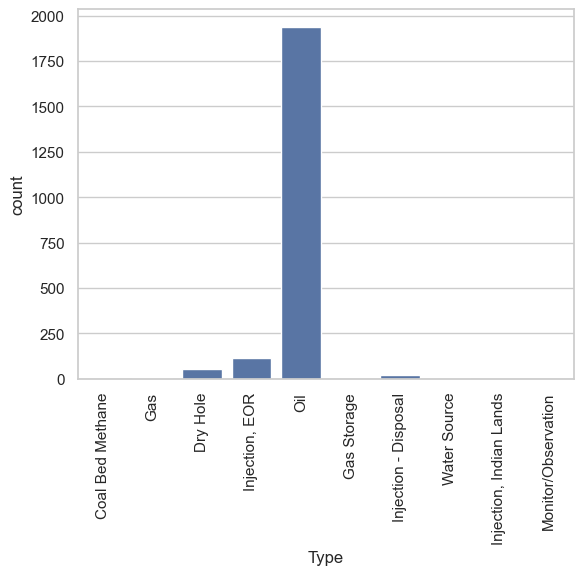

In [18]:
sns.set_theme(style="whitegrid")
ax = sns.countplot(x="Type", data=hz_wells)
ax.tick_params(axis='x', rotation=90)

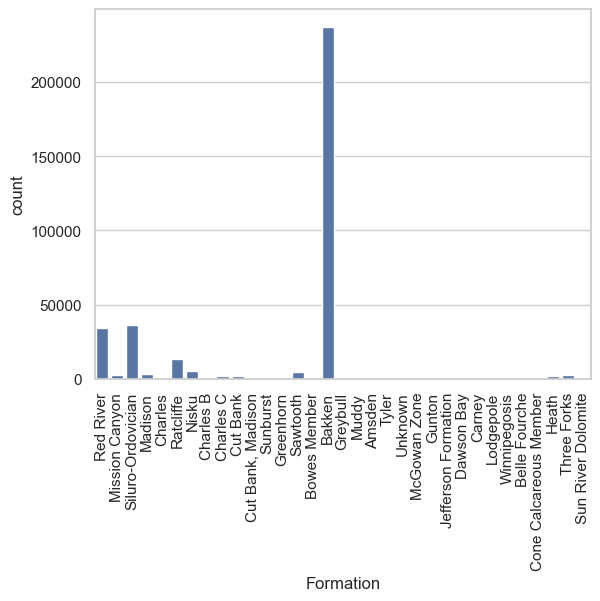

In [19]:
sns.set_theme(style="whitegrid")
ax = sns.countplot(x="Formation", data=hz_wells_prod)
ax.tick_params(axis='x', rotation=90)

## Stimulation Information
Let's continue by analyzing the data from FracFocus. Many of the ingredients were applicable have a CAS (Chemical Abstract Service )number associated with the component ingredients. You can look them up [here](https://commonchemistry.cas.org/) . The most common ingredient is 'Properietary', and 'Trade Secret' as well as 'Confidential are listed in the top 10. 7732-18-5 is the CAS number for water, next is 14808-60-7 which is quartz. The other numbers correspond to various alcohols and petroleum distillates.

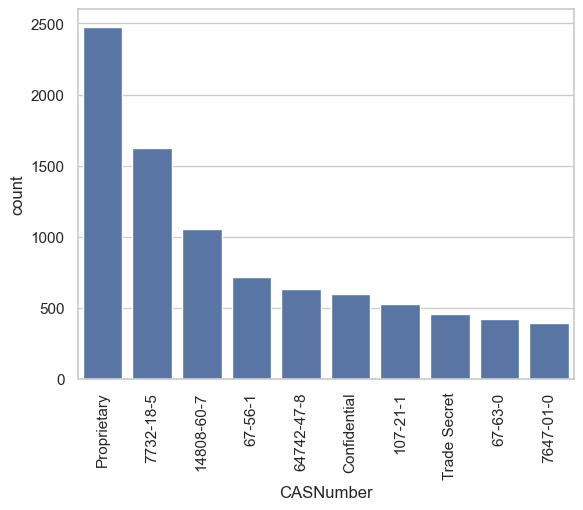

In [20]:
sns.set_theme(style="whitegrid")
ax = sns.countplot(x="CASNumber", data=FracFocusRegistry_df_MT,
              order=FracFocusRegistry_df_MT.CASNumber.value_counts().iloc[:10].index)
ax.tick_params(axis='x', rotation=90)

What purpose do these materials serve? Looking at value counts, 'Other' seems to be a top category, but the others are proppant (corresponding to quartz), biocide and breaker

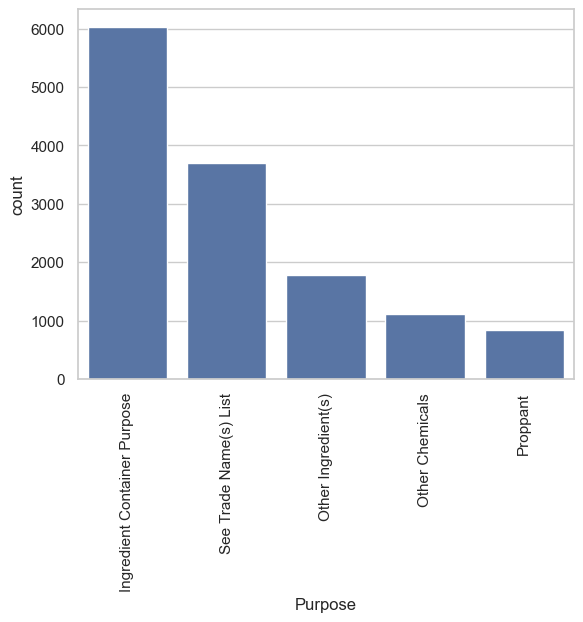

In [21]:
sns.set_theme(style="whitegrid")
ax = sns.countplot(x="Purpose", data=FracFocusRegistry_df_MT,
              order=FracFocusRegistry_df_MT.Purpose.value_counts().iloc[:5].index)
ax.tick_params(axis='x', rotation=90)

How much of these chemicals are pumped on an particular job? if we look at a histogram of the percentage volume, we can see that these chemicals only make up a small percentage of the total material being pumped. 

(0.0, 0.05)

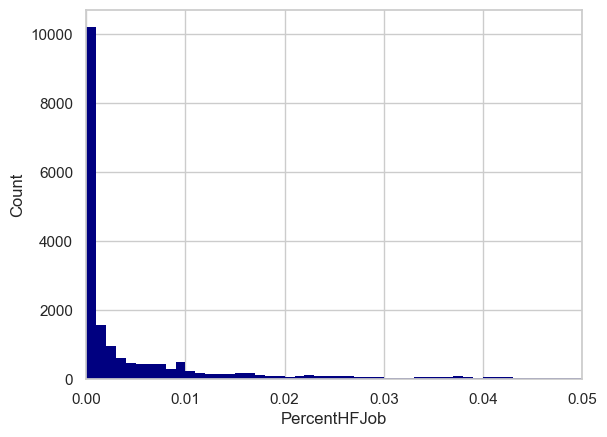

In [22]:
sns.histplot(data = FracFocusRegistry_df_MT
            ,x = 'PercentHFJob'
            ,color = 'navy'
            ,alpha = 1
            ,binwidth = .001
            )
plt.xlim(0, .05)

So what is the primary component of these treatments? If we sort by the `PercentHFJob` and inspect the `IngredientName` and `CASNumber` columns we can see that primary component is typically water.

In [23]:
FracFocusRegistry_df_MT.sort_values(by=['PercentHFJob'], ascending= False).head(n=10)

DisclosureId  \
FracFocusRegistry_14.csv 128085  2662014e-f985-4ae6-ab57-6db720f4b5cf   
                         142641  f9505f72-68b1-4b23-83c6-749e23de0358   
                         142436  3bfd66fb-cf3b-434a-bf2a-90d58cf963f2   
                         142266  12e67b82-acb6-4a95-9a8d-38c3b754dcc6   
                         141597  6e4dd2f1-3cc3-4837-b244-d747433674ad   
FracFocusRegistry_13.csv 240986  918b70e7-3d23-4d2b-a824-47cfdfbf35a1   
                         246296  a3b82463-749d-4067-b151-22f45543d3a9   
                         246251  5f984fdb-e6be-4925-9973-7e6e153c53d0   
                         209412  d667216b-54b9-4848-b963-94a1e9c7b3d4   
                         265928  440b9bf4-5c31-466b-9b0e-7a3115a65508   

                                          JobStartDate             JobEndDate  \
FracFocusRegistry_14.csv 128085    8/7/2024 6:19:00 PM    8/8/2024 2:25:00 PM   
                         142641   7/31/2024 7:24:00 PM   8/24/2024 1:32:00 AM   
                         142436   7/31/2024 5:55:00 PM  8/24/2024 12:00:00 AM   
                         142266   7/31/2024 2:20:00 PM  8/23/2024 11:00:00 PM   
                         141597   7/31/2024 4:15:00 PM   8/23/2024 3:45:00 AM   
FracFocusRegistry_13.csv 240986  6/23/2023 12:00:00 AM  6/27/2023 12:00:00 AM   
                         246296  6/23/2023 12:00:00 AM   7/2/2023 12:00:00 AM   
                         246251  6/23/2023 12:00:00 AM   7/2/2023 12:00:00 AM   
                         209412   5/25/2023 5:00:00 AM   5/29/2023 5:00:00 AM   
                         265928   7/4/2023 12:00:00 AM  7/21/2023 12:00:00 AM   

                                      APINumber StateName CountyName  \
FracFocusRegistry_14.csv 128085  25083225270000   Montana   Richland   
                         142641  25085220510000   Montana  Roosevelt   
                         142436  25085220500000   Montana  Roosevelt   
                         142266  25085220480000   Montana  Roosevelt   
                         141597  25085220490000   Montana  Roosevelt   
FracFocusRegistry_13.csv 240986  25083234450000   Montana   Richland   
                         246296  25083234470000   Montana   Richland   
                         246251  25083234460000   Montana   Richland   
                         209412  25083220400000   Montana   Richland   
                         265928  25085220240000   Montana  Roosevelt   

                                         OperatorName  \
FracFocusRegistry_14.csv 128085   EMEP Operating, LLC   
                         142641  Kraken Operating LLC   
                         142436  Kraken Operating LLC   
                         142266  Kraken Operating LLC   
                         141597  Kraken Operating LLC   
FracFocusRegistry_13.csv 240986  Kraken Operating LLC   
                         246296  Kraken Operating LLC   
                         246251  Kraken Operating LLC   
                         209412   EMEP Operating, LLC   
                         265928  Kraken Operating LLC   

                                                 WellName   Latitude  \
FracFocusRegistry_14.csv 128085  Peanut East Hines 11-14H  47.848983   
                         142641         Lucero 4-33-28 2H  48.112452   
                         142436         Lucero 4-33-28 1H  48.112543   
                         142266       Felix 9-16-21-28 4H  48.112723   
                         141597       Felix 9-16-21-28 5H  48.112633   
FracFocusRegistry_13.csv 240986            Hardy 16-21 2H  47.927159   
                         246296            Hardy 16-21 4H  47.927159   
                         246251            Hardy 16-21 3H  47.927159   
                         209412   Stockade Gunderson 2-7H  47.863288   
                         265928         Fred 15-22-27 #2H  48.098610   

                                  Longitude  ... IngredientCommonName  \
FracFocusRegistry_14.csv 128085 -104.370756  ...                Water   
 

Finally, it would be interesting to know how many wells do we have both FracFocus and State data on as well as the breakdown for the corresponding formation and well type.

In [24]:
sum(hz_wells.API_WellNo.isin(list(map(int,list(registryupload_df_MT.APINumber)))))

770

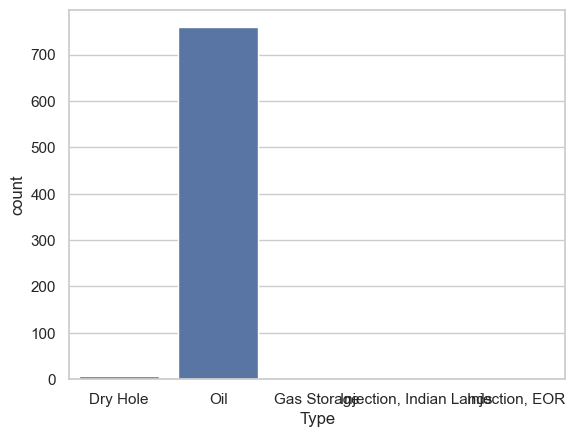

In [25]:
sns.set_theme(style="whitegrid")
ax = sns.countplot(x="Type", data=hz_wells[hz_wells.API_WellNo.isin(list(map(int,list(registryupload_df_MT.APINumber))))])

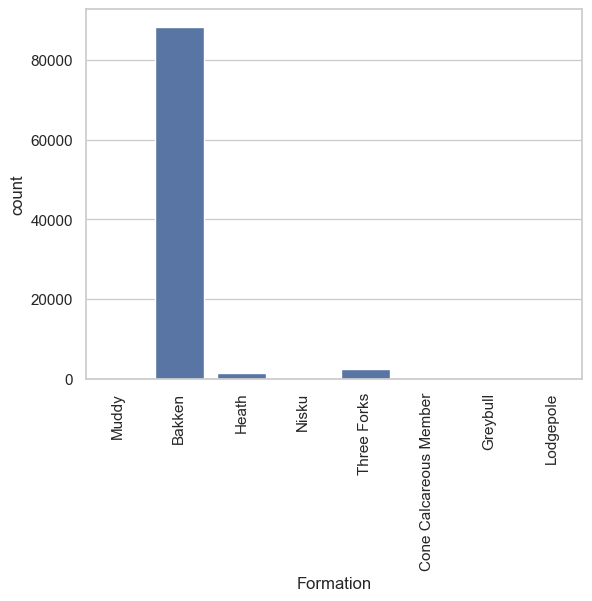

In [26]:
sns.set_theme(style="whitegrid")
ax = sns.countplot(x="Formation", data=hz_wells_prod[hz_wells_prod.API_WellNo.isin(list(map(int,list(registryupload_df_MT.APINumber))))])
ax.tick_params(axis='x', rotation=90)

So out of over 1700 horizontal wells we have FracFocus data for 675, which are overwhelmingly oil wells completed in the Bakken formation

## Model Well Performance
From the available data, let's see if we can model well performance. Before a well is drilled and completed, it's formation, stimulation design, location will all be known. Let's predict the cumulative BOE (bbls of oil equivalent) as a function of these factors.

Let's start with preprocessing and cleansing the data to get a dataset with cumulative 720 well BOE as the dependent variable, and variables like the formation, drilling slant, and stimulation volume as the dependent variables.

In [27]:
ff_data = preprocess_ff_data(FracFocusRegistry_df_MT)
well_df = preprocess_well_data(well_data_df)
totals_df = preprocess_prod_data(well_prod_df)
data = merge_data(totals_df, well_df, ff_data, interval=720)
data.head()

/Users/josephromani/MT_Oil/prod_model.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["TOTAL_DAYS"] = df.groupby("API_WellNo")["DAYS_PROD"].cumsum()


,Zone,Lat,Long,Slant,PercentHFJob,MassIngredient,TVD,TotalBaseWaterVolume,TotalBaseNonWaterVolume,BOE
API_WellNo,,,,,,,,,,
25009212970000,GRE,45.30899,-109.58579,Horizontal,15.547242,475294.85,3463.0,65482.0,NaN,9740.827586
25021211950000,RR,47.36625,-104.55884,Vertical,16.989885,88984.00,12000.0,54687.0,NaN,41430.620690
25075210200000,MUD,45.11476,-105.08690,Vertical,NaN,NaN,4370.0,11950.0,NaN,133911.206897
25075210490000,MUD,45.14368,-105.06135,Vertical,NaN,NaN,4594.0,11785.0,NaN,149605.000000
25075213900000,MUD,45.10388,-105.07155,Vertical,NaN,NaN,4331.0,11500.0,NaN,99656.931034


Now for the ML pipeline, which will do scaling, reimputing missing data, and one-hot encoding categorical data. Which gives us and R^2 on the test data of over 0.4 . Considering all the other factors that go into well a well's productivity, such as the number of stages, lateral length in the case of horizontals, methods of production (gas lift, sucker rod, etc) I would consider this a reasonable result. 

In [28]:
train_and_evaluate(data)

Mean Absolute Error: 29012.05614942529
R^2: 0.4614782717473924
Actuals vs. Predicted saved to actuals_vs_predicted.csv
